In [1]:
# Use if you run the notebook on Google colab
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
!pip install mglearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 9.9 MB/s eta 0:00:00


# 8: Decision Trees

## Imports

In [3]:
import glob
import os
import re
import sys
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append("/content/drive/MyDrive/50603/code")
os.chdir('/content/drive/MyDrive/50603')
import graphviz
import IPython
import mglearn
from IPython.display import Image, HTML, display
from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from utils import *

plt.rcParams["font.size"] = 16
pd.set_option("display.max_colwidth", 200)


<br><br>

## Decision trees [[video](https://youtu.be/Hcf19Ij35rA)]


Check out [the accompanying video](https://youtu.be/Hcf19Ij35rA) on this material.


### Writing a traditional program to predict quiz2 grade

- Can we do better than random guess?
- Forget about ML for a second. If you are asked to write a program to predict whether a student gets an A+ or not in quiz2, how would you go for it?  
- For simplicity, let's binarize the feature values.

![](img/quiz2-grade-toy.png)

<!-- <img src="img/quiz2-grade-toy.png" height="700" width="700">  -->


- Is there a pattern that distinguishes yes's from no's and what does the pattern say about today?
- How about a rule-based algorithm with a number of *if else* statements?  

    if class_attendance == 1 and quiz1 == 1:
        quiz2 == "A+"
    elif class_attendance == 1 and lab3 == 1 and lab4 == 1:
        quiz2 == "A+"
    ...


- How many possible rule combinations there could be with the given 7 binary features?
    - Gets unwieldy pretty quickly

### Decision tree algorithm

- A machine learning algorithm to derive such rules from data in a principled way.  
- Have you ever played [20-questions game](https://en.wikipedia.org/wiki/Twenty_questions)? Decision trees are based on the same idea!
- Let's `fit` a decision tree using `scikit-learn` and `predict` with it.
- Recall that `scikit-learn` uses the term `fit` for training or learning and uses `predict` for prediction.

### Building decision trees with `sklearn`

Let's **binarize** our toy dataset for simplicity.

In [4]:
classification_df = pd.read_csv("data/quiz2-grade-toy-classification.csv")
X = classification_df.drop(columns=["quiz2"])
y = classification_df["quiz2"]

X_binary = X.copy()
columns = ["lab1", "lab2", "lab3", "lab4", "quiz1"]
for col in columns:
    X_binary[col] = X_binary[col].apply(lambda x: 1 if x >= 90 else 0)

X_binary.head()

,ml_experience,class_attendance,lab1,lab2,lab3,lab4,quiz1
0,1,1,1,1,0,1,1
1,1,0,1,1,0,0,1
2,0,0,0,0,0,0,0
3,0,1,1,1,1,1,0
4,0,1,0,0,1,1,0


In [5]:
y.head()

,quiz2
0,A+
1,not A+
2,not A+
3,A+
4,A+


#### `DummyClassifier` on quiz2 grade prediction toy dataset

In [6]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_binary, y)
dummy_clf.score(X_binary, y)

0.5238095238095238

#### `DecisionTreeClassifier` on quiz2 grade prediction toy dataset

In [7]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier() # Create a decision tree
model.fit(X_binary, y) # Fit a decision tree
model.score(X_binary, y) # Assess the model

0.9047619047619048

The decision tree classifier is giving much higher accuracy than the dummy classifier. That's good news!

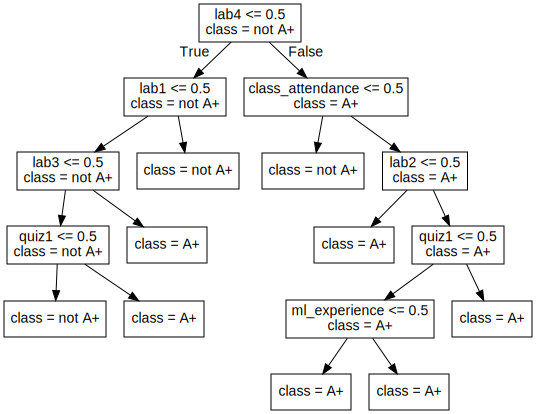

In [8]:
display_tree(X_binary.columns, model) # model visualization

### Some terminology related to trees

Here is a commonly used terminology in a typical representation of decision trees.

**A root node**
: represents the *first condition* to check or question to ask

**A branch**
: *connects* a node (condition) to the next node (condition) in the tree. Each branch typically represents either true or false.

**An internal node**
: represents conditions *within* the tree

**A leaf node**
: represents the *predicted class/value* when the path from root to the leaf node is followed.

**Tree depth**
: The *number of edges* on the path from the root node to the farthest away leaf node.

### How does `predict` work?

In [9]:
new_example = np.array([[0, 1, 0, 0, 1, 1, 1]])
new_example = pd.DataFrame(data=new_example, columns=X.columns)
new_example

,ml_experience,class_attendance,lab1,lab2,lab3,lab4,quiz1
0,0,1,0,0,1,1,1


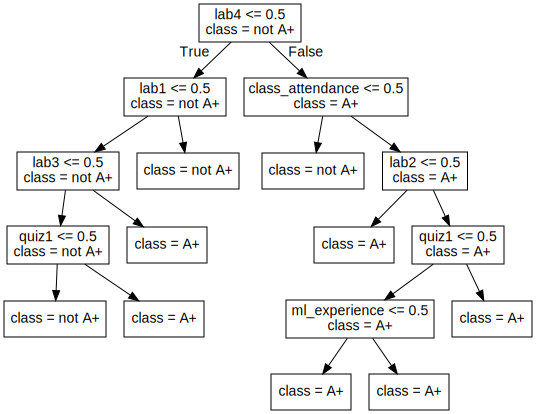

In [10]:
display_tree(X_binary.columns, model)

What's the prediction for the new example?

In [11]:
model.predict(new_example)

array(['A+'], dtype=object)

In summary, given a learned tree and a test example, during prediction time,  
- Start at the top of the tree. Ask binary questions at each node and follow the appropriate path in the tree. Once you are at a leaf node, you have the prediction.
- Note that the model only considers the features which are in the learned tree and ignores all other features.

### How does `fit` work?

- Decision tree is inspired by [20-questions game](https://en.wikipedia.org/wiki/Twenty_questions).
- Each node either represents a question or an answer. The terminal nodes (called leaf nodes) represent answers.

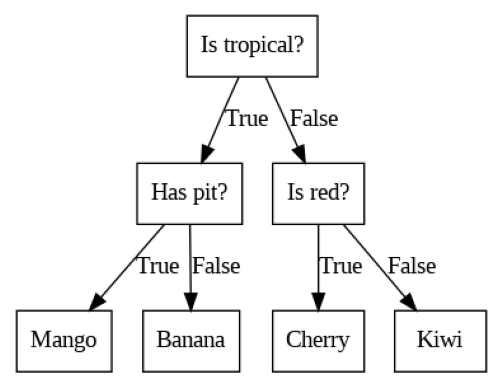

In [12]:
plot_fruit_tree()

### How does `fit` work?

- Which features are most useful for classification?
- Minimize **impurity** at each question
- Common criteria to minimize impurity: [gini index](https://scikit-learn.org/stable/modules/tree.html#classification-criteria), information gain, cross entropy

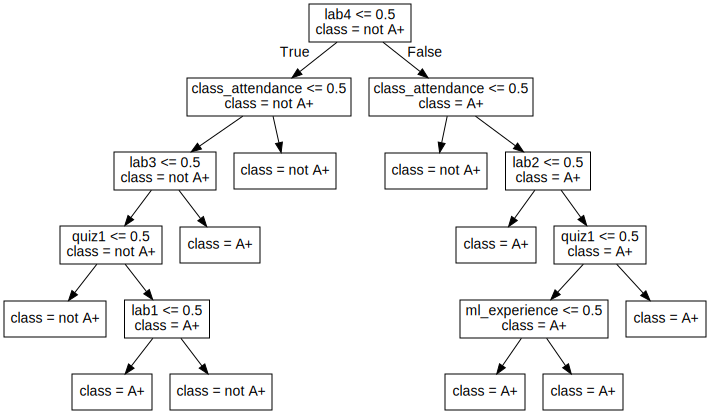

In [13]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier() # Create a decision tree
model.fit(X_binary, y) # Fit a decision tree
display_tree(X_binary.columns, model)

### Decision trees with **continuous** features

In [14]:
X.head()

,ml_experience,class_attendance,lab1,lab2,lab3,lab4,quiz1
0,1,1,92,93,84,91,92
1,1,0,94,90,80,83,91
2,0,0,78,85,83,80,80
3,0,1,91,94,92,91,89
4,0,1,77,83,90,92,85


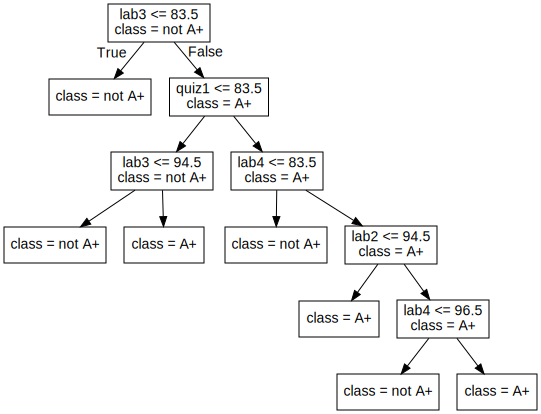

In [15]:
model = DecisionTreeClassifier()
model.fit(X, y)
display_tree(X.columns, model)

### Decision tree for regression problems

- We can also use decision tree algorithm for regression.
- Instead of gini, we use [some other criteria](https://scikit-learn.org/stable/modules/tree.html#mathematical-formulation) for splitting. A common one is mean squared error (MSE). (More on this in later videos.)
- `scikit-learn` supports regression using decision trees with `DecisionTreeRegressor`
    - `fit` and `predict` paradigms similar to classification
    - `score` returns somethings called [$R^2$ score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score).     
        - The maximum $R^2$ is 1 for perfect predictions.
        - It can be negative which is very bad (worse than `DummyRegressor`).


In [16]:
regression_df = pd.read_csv("data/quiz2-grade-toy-regression.csv")
regression_df.head()

,ml_experience,class_attendance,lab1,lab2,lab3,lab4,quiz1,quiz2
0,1,1,92,93,84,91,92,90
1,1,0,94,90,80,83,91,84
2,0,0,78,85,83,80,80,82
3,0,1,91,94,92,91,89,92
4,0,1,77,83,90,92,85,90


In [17]:
X = regression_df.drop(["quiz2"], axis=1)
y = regression_df["quiz2"]

depth = 2
reg_model = DecisionTreeRegressor(max_depth=depth)
reg_model.fit(X, y);
regression_df["predicted_quiz2"] = reg_model.predict(X)
print("R^2 score on the training data: %0.3f\n\n" % (reg_model.score(X, y)))
regression_df.head()

R^2 score on the training data: 0.989




,ml_experience,class_attendance,lab1,lab2,lab3,lab4,quiz1,quiz2,predicted_quiz2
0,1,1,92,93,84,91,92,90,90.333333
1,1,0,94,90,80,83,91,84,83.000000
2,0,0,78,85,83,80,80,82,83.000000
3,0,1,91,94,92,91,89,92,92.000000
4,0,1,77,83,90,92,85,90,90.333333


<br><br>

## More terminology [[video](https://youtu.be/KEtsfXn4w2E)]

- Parameters and hyperparameters
- Decision boundary



Check out [the accompanying video](https://youtu.be/KEtsfXn4w2E) on this material.


### Parameters

- The decision tree algorithm primarily **learns two** things:
    - the **best feature** to split on
    - the **threshold** for the feature to split on at each node
- These are called ***parameters*** of the decision tree model.  
- When predicting on new examples, we need parameters of the model.

In [18]:
classification_df = pd.read_csv("data/quiz2-grade-toy-classification.csv")
X = classification_df.drop(columns=["quiz2"])
y = classification_df["quiz2"]
model = DecisionTreeClassifier()
model.fit(X, y);

In [19]:
X.head()

,ml_experience,class_attendance,lab1,lab2,lab3,lab4,quiz1
0,1,1,92,93,84,91,92
1,1,0,94,90,80,83,91
2,0,0,78,85,83,80,80
3,0,1,91,94,92,91,89
4,0,1,77,83,90,92,85


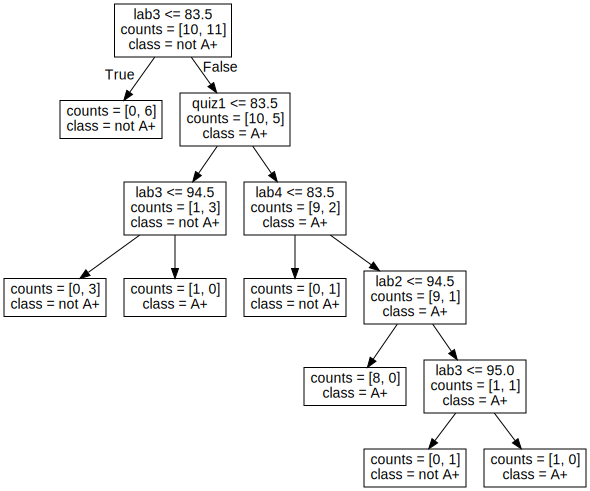

In [20]:
display_tree(X.columns, model, counts=True)

- With the default setting, the nodes are expanded until all leaves are "**pure**".

- The decision tree is creating very specific rules, based on just one example from the data.
- Is it possible to control the learning in any way?
    - Yes! One way to do it is by controlling the **depth** of the tree, which is the length of the longest path from the tree root to a leaf.    

### Decision tree with `max_depth=1`

**Decision stump**
: A decision tree with only one split (depth=1) is called a **decision stump**.

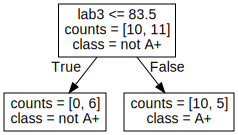

In [21]:
model = DecisionTreeClassifier(max_depth=1)
model.fit(X, y)
display_tree(X.columns, model, counts=True)

`max_depth` is a **hyperparameter** of `DecisionTreeClassifier`.

### Decision tree with `max_depth=3`

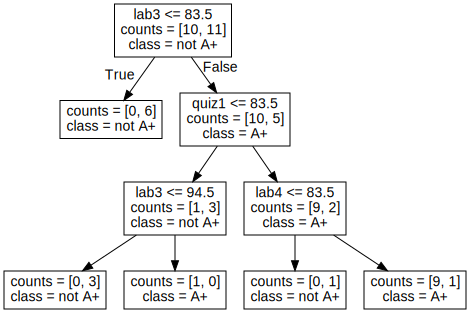

In [22]:
model = DecisionTreeClassifier(
    max_depth=3
)  # Let's try another value for the hyperparameter
model.fit(X, y)
display_tree(X.columns, model, counts=True)

### Parameters and hyperparameters: Summary
**Parameters**
: When you call `fit`, a bunch of values get set, like the features to split on and split thresholds. These are called **parameters**. These are learned by the algorithm from the data during training. We need them during prediction time.

**Hyperparameters**
: Even before calling `fit` on a specific data set, we can set some "knobs" that control the learning. These are called **hyperparameters**. These are specified based on: expert knowledge, heuristics, or systematic/automated optimization (more on this in the coming lectures).    

 Attention

In `sklearn` hyperparameters are set in the constructor.


Above we looked at the `max_depth` hyperparameter. Some other commonly used hyperparameters of decision tree are:

- `min_samples_split`
- `min_samples_leaf`
- `max_leaf_nodes`


See [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for other hyperparameters of a tree.


### Decision boundary

What do we do with learned models? So far we have been using them to predict the class of a new instance. Another way to think about them is to ask: what sort of test examples will the model classify as positive, and what sort will it classify as negative?

#### Example 1: quiz 2 grade prediction

For visualization purposes, let's consider a subset of the data with only two features.

In [23]:
X_subset = X[["lab4", "quiz1"]]
X_subset.head()

,lab4,quiz1
0,91,92
1,83,91
2,80,80
3,91,89
4,92,85


#### Decision boundary for `max_depth=1`

A decision tree with only one split (depth=1) is called a **decision stump**.

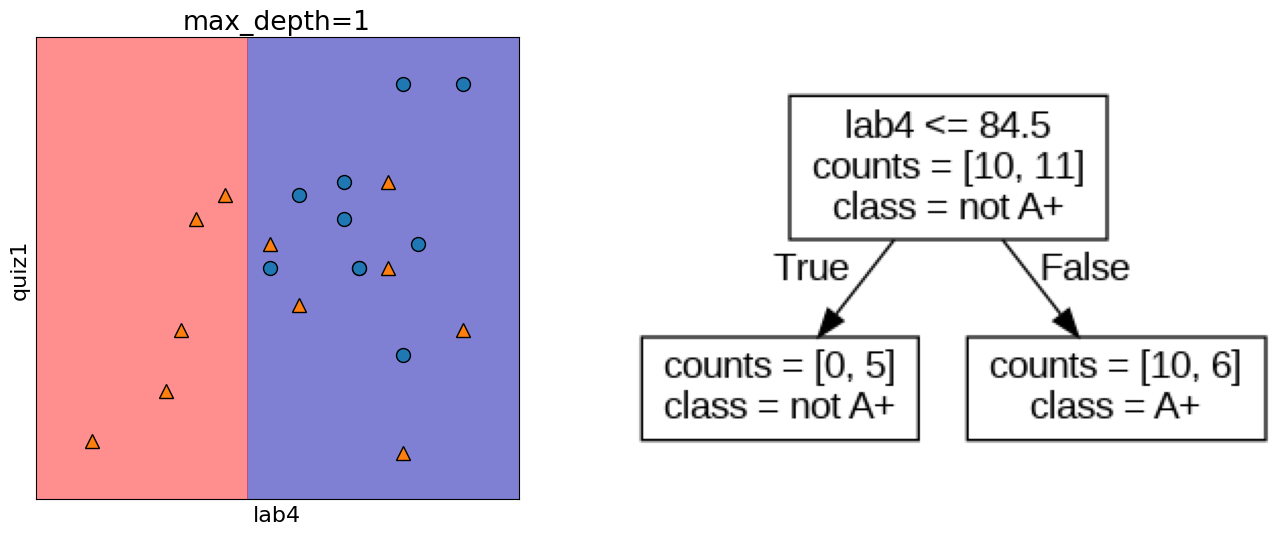

In [24]:
depth = 1  # decision stump
model = DecisionTreeClassifier(max_depth=depth)
model.fit(X_subset, y)
plot_tree_decision_boundary_and_tree(
    model, X_subset, y, x_label="lab4", y_label="quiz1"
)

We assume geometric view of the data. Here, the red region corresponds to "not A+" class and blue region corresponds to "A+" class. And there is a line separating the red region and the blue region which is called the **decision boundary** of the model. Different models have different kinds of decision boundaries.
In decision tree models, when we are working with only two features, the decision boundary is made up of horizontal and vertical lines. In the example above, the decision boundary is created by asking one question `lab4 <= 84.5`.

#### Decision boundary for `max_depth=2`

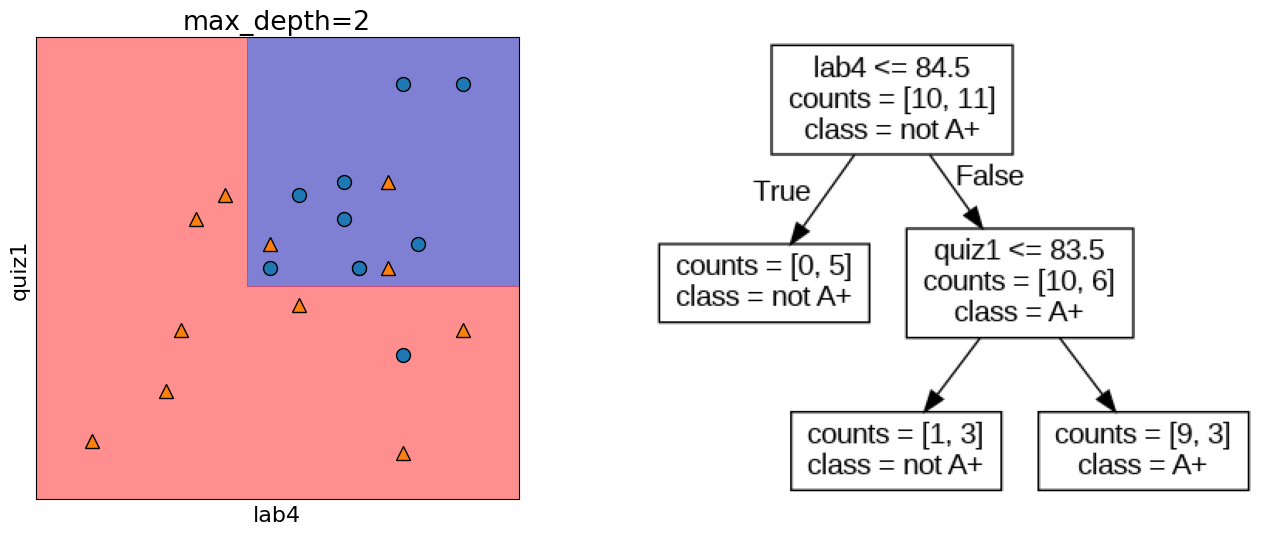

In [25]:
model = DecisionTreeClassifier(max_depth=2)
model.fit(X_subset, y)
plot_tree_decision_boundary_and_tree(
    model, X_subset, y, x_label="lab4", y_label="quiz1"
)

The decision boundary, i.e., the model gets a bit more complicated.

#### Decision boundary for `max_depth=5`

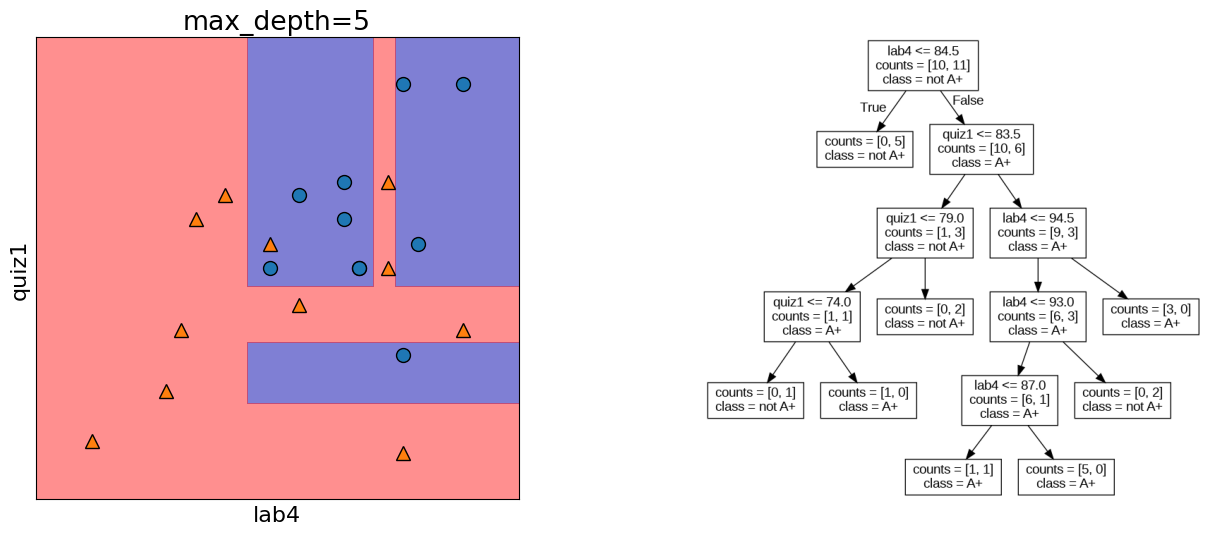

In [26]:
model = DecisionTreeClassifier(max_depth=5)
model.fit(X_subset, y)
plot_tree_decision_boundary_and_tree(
    model, X_subset, y, x_label="lab4", y_label="quiz1"
)

The decision boundary, i.e., the model gets even more complicated with `max_depth=5`.

<br><br>

#### Example 2: Predicting country using the longitude and latitude

You are given longitude and latitude of some border cities of USA and Canada along with which country they belong to. Using this training data, you are supposed to come up with a classification model to predict whether a given longitude and latitude combination is in the USA or Canada.

In [27]:
### US Canada cities data
df = pd.read_csv("data/canada_usa_cities.csv")
df

,longitude,latitude,country
0,-130.0437,55.9773,USA
1,-134.4197,58.3019,USA
2,-123.0780,48.9854,USA
3,-122.7436,48.9881,USA
4,-122.2691,48.9951,USA
...,...,...,...
204,-72.7218,45.3990,Canada
205,-66.6458,45.9664,Canada
206,-79.2506,42.9931,Canada
207,-72.9406,45.6275,Canada


In [28]:
X = df[["longitude", "latitude"]]

In [29]:
y = df["country"]

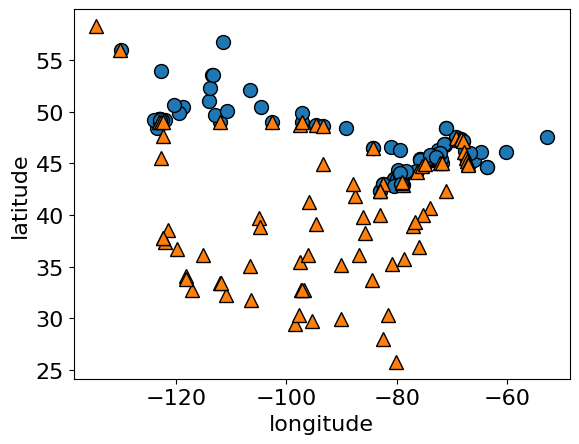

In [30]:
mglearn.discrete_scatter(X.iloc[:, 0], X.iloc[:, 1], y)
plt.xlabel("longitude")
plt.ylabel("latitude");

##### Real boundary between Canada and USA

In real life we know what's the boundary between USA and Canada.

![](img/canada-us-border.jpg)

<!-- <img src="img/canada-us-border.jpg" height="500" width="500">  -->

[Source](https://sovereignlimits.com/blog/u-s-canada-border-history-disputes)

Here we want to pretend that we do not know this boundary and we want to infer this boundary based on the limited training examples given to us.

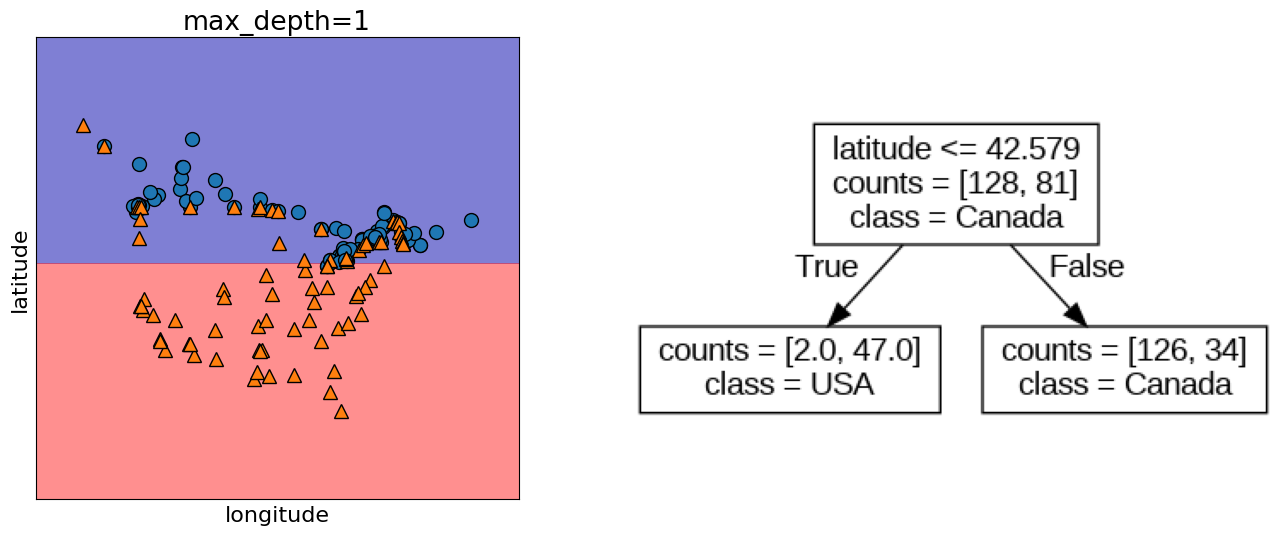

In [31]:
model = DecisionTreeClassifier(max_depth=1)
model.fit(X, y)
plot_tree_decision_boundary_and_tree(
    model,
    X,
    y,
    height=6,
    width=16,
    eps=10,
    x_label="longitude",
    y_label="latitude",
)

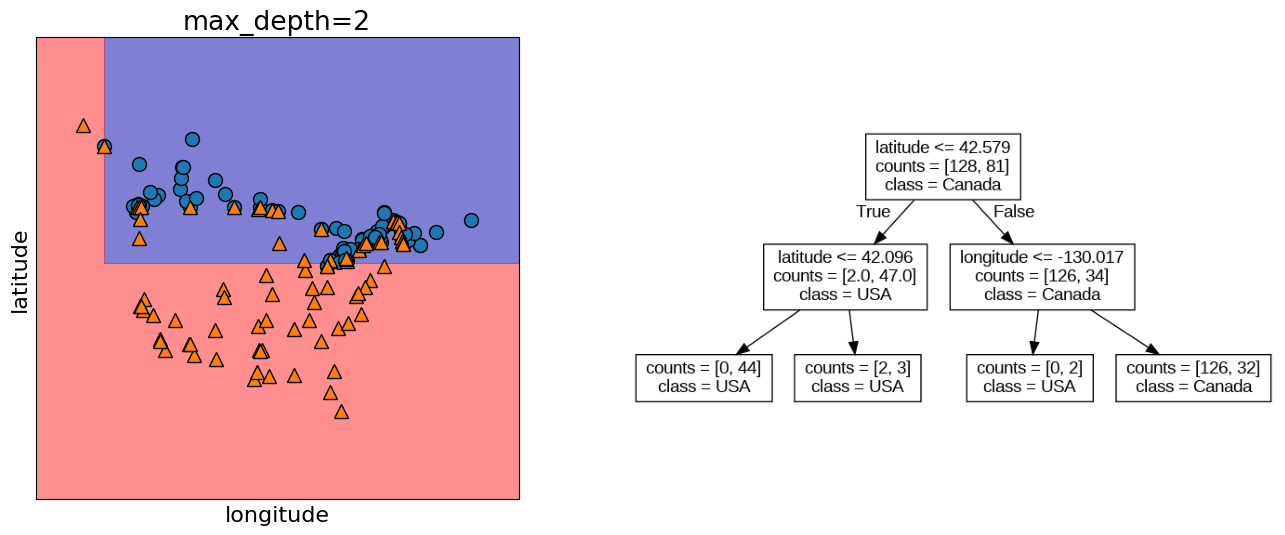

In [32]:
model = DecisionTreeClassifier(max_depth=2)
model.fit(X, y)
plot_tree_decision_boundary_and_tree(
    model,
    X,
    y,
    height=6,
    width=16,
    eps=10,
    x_label="longitude",
    y_label="latitude",
)